In [66]:
import sys, yaml
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, butter, lfilter, freqz
from scipy.ndimage import uniform_filter1d
from scipy.optimize import minimize, Bounds
from scipy.stats import fit
import scipy
from motoman_def import *
sys.path.append("../toolbox/")
sys.path.append("")
from angled_layers import *
%matplotlib widget

In [2]:
dataset='bent_tube/'
sliced_alg='slice_ER_4043/'
data_dir='../data/'+dataset+sliced_alg

config_dir='../config/'
flir_intrinsic=yaml.load(open(config_dir+'FLIR_A320.yaml'), Loader=yaml.FullLoader)
with open(data_dir+'slicing.yml', 'r') as file:
	slicing_meta = yaml.safe_load(file)
por = slicing_meta['point_of_rotation']
angle = slicing_meta['layer_angle']

with open(data_dir+'slicing.yml', 'r') as file:
	slicing_meta = yaml.safe_load(file)
base_thickness = slicing_meta['baselayer_thickness']

robot=robot_obj('MA2010_A0',def_path='../config/MA2010_A0_robot_default_config.yml',tool_file_path='../config/torch.csv',\
	pulse2deg_file_path='../config/MA2010_A0_pulse2deg_real.csv',d=15)
robot2=robot_obj('MA1440_A0',def_path='../config/MA1440_A0_robot_default_config.yml',tool_file_path='../config/flir.csv',\
	pulse2deg_file_path='../config/MA1440_A0_pulse2deg_real.csv',base_transformation_file='../config/MA1440_pose.csv')
positioner=positioner_obj('D500B',def_path='../config/D500B_robot_extended_config.yml',tool_file_path='../config/positioner_tcp.csv',\
	pulse2deg_file_path='../config/D500B_pulse2deg_real.csv',base_transformation_file='../config/D500B_pose.csv')

save_path = f'../../recorded_data/ER4043_bent_tube_2024_08_22_11_12_27/'
H = np.loadtxt(data_dir+'curve_pose.csv', delimiter=',')

# Load Data

In [3]:
job_no_offset = 3
joint_angles = []
for layer in range(1,80):
    try:
        joint_angles_layer = np.loadtxt(save_path+f'layer_{layer}/weld_js_exe.csv', delimiter=',')
    except FileNotFoundError:
        joint_angles_layer = [None]
    joint_angles.append(joint_angles_layer)
print(joint_angles[0].shape)

(5154, 16)


In [4]:
layer_dir = []
for layer in range(1,80):
    layer_dir.append(np.loadtxt(save_path+f'layer_{layer}/start_dir.csv', delimiter=','))

In [5]:
# velocity setpoints
set_vel = []
for layer in range(1,80):
    layer_vel_profile = np.loadtxt(save_path+f'layer_{layer}/velocity_profile.csv', delimiter=',')

    if not layer_dir[layer-1]:
            layer_vel_profile = layer_vel_profile[::-1]
    set_vel.append(layer_vel_profile)

print(len(set_vel))

79


In [6]:
'''height error: rotate the flame data down to 0, and record height'''
p = H[:3, -1]
R = H[:3, :3]
height_offset = -4.51
height_data = []
point_of_rotation = np.array(
        (slicing_meta["point_of_rotation"], slicing_meta["baselayer_thickness"])
    )
layer_angle = np.array((slicing_meta["layer_angle"]))

for layer in range(1,80):
    to_flat_angle = np.deg2rad(layer_angle * (layer - 1))
    start_dir = not np.loadtxt(f"{save_path}layer_{layer}/start_dir.csv", delimiter=",")
    try:
        flame_3d, _, job_no = flame_tracking(f"{save_path}layer_{layer}/", robot, robot2, positioner, flir_intrinsic, height_offset)
        if flame_3d.shape[0] == 0:
            raise ValueError("No flame detected")
    except ValueError as e:
        print(e)
        flame_3d = None
    except FileNotFoundError as e:
        print(e)
        flame_3d = None
    else:    
        height_data.append(flame_3d)
        




[Errno 2] No such file or directory: '../../recorded_data/ER4043_bent_tube_2024_08_22_11_12_27/layer_25/ir_recording.pickle'


In [25]:
# Rotate to flat to generate model data
dhs = []
vels = []

num_layer_start = 1
num_layer_end = 80

for layer in range(num_layer_start, num_layer_end):
    ### Load Data
    curve_sliced_js = np.loadtxt(
        data_dir + f"curve_sliced_js/MA2010_js{layer}_0.csv", delimiter=","
    ).reshape((-1, 6))

    positioner_js = np.loadtxt(
        data_dir + f"curve_sliced_js/D500B_js{layer}_0.csv", delimiter=","
    )
    curve_sliced_relative = np.loadtxt(
        data_dir + f"curve_sliced_relative/slice{layer}_0.csv", delimiter=","
    )
    curve_sliced = np.loadtxt(
        data_dir + f"curve_sliced/slice{layer}_0.csv", delimiter=","
    )
    to_flat_angle = np.deg2rad(layer_angle * (layer - 1))
    dh_max = slicing_meta["dh_max"]
    dh_min = slicing_meta["dh_min"]
    
    ##calculate distance to point of rotation
    dist_to_por = []
    for i in range(len(curve_sliced)):
        point = np.array((curve_sliced[i, 0], curve_sliced[i, 2]))
        dist = np.linalg.norm(point - point_of_rotation)
        dist_to_por.append(dist)

    height_profile = []
    for distance in dist_to_por:
        height_profile.append(distance * np.sin(np.deg2rad(layer_angle)))

    if layer == 1: 
        start_dir=True
        model = SpeedHeightModel()
        vel_nom = model.dh2v(height_profile)
        velocity_profile = vel_nom
    else: 
        try:
            start_dir = not np.loadtxt(f"{save_path}layer_{layer-1}/start_dir.csv", delimiter=",")

            # Initialize model with previous layer's coefficients
            model_coeff = np.loadtxt(f"{save_path}layer_{layer-1}/coeff_mat.csv", delimiter=",")
            model_p = np.loadtxt(f"{save_path}layer_{layer-1}/model_p.csv", delimiter=",")
            model = SpeedHeightModel(a = model_coeff[0], b = model_coeff[1], p = model_p)
            vel_nom = model.dh2v(height_profile) #updated later down if model updates

            
            ir_error_flag = False
            ### Process IR data prev 
            try:
                flame_3d_prev, _, job_no_prev = flame_tracking(f"{save_path}layer_{layer-1}/", robot, robot2, positioner, flir_intrinsic, height_offset)
                if flame_3d_prev.shape[0] == 0:
                    raise ValueError("No flame detected")
            except ValueError as e:
                print(e)
                flame_3d_prev = None
                ir_error_flag = True
            else:
                # rotate to flat
                for i in range(flame_3d_prev.shape[0]):
                    flame_3d_prev[i] = R.T @ flame_3d_prev[i] 
                
                new_x, new_z = rotate(
                    point_of_rotation, (flame_3d_prev[:, 0], flame_3d_prev[:, 2]), to_flat_angle
                )
                flame_3d_prev[:, 0] = new_x
                flame_3d_prev[:, 2] = new_z - base_thickness

                job_no_prev = [i - job_no_offset for i in job_no_prev]
                averages_prev = avg_by_line(job_no_prev, flame_3d_prev, np.linspace(0,len(curve_sliced_js)-1,len(curve_sliced_js)))
                heights_prev = averages_prev[:,2]
                if start_dir: heights_prev = np.flip(heights_prev)
                # Find Valid datapoints for height correction
                prev_idx = np.argwhere(np.invert(np.isnan(heights_prev)))

                ### Process IR data 2 prev
                try:
                    flame_3d_prev_2, _, job_no_prev_2 = flame_tracking(f"{save_path}layer_{layer-2}/", robot, robot2, positioner, flir_intrinsic, height_offset)
                    # print(flame_3d_prev_2.shape)
                except ValueError as e:
                    print(e)
                    ir_error_flag = True
                else:
                    # print(ir_error_flag)
                    # rotate to flat
                    for i in range(flame_3d_prev_2.shape[0]):
                        flame_3d_prev_2[i] = R.T @ flame_3d_prev_2[i] 
                    
                    new_x, new_z = rotate(
                        point_of_rotation, (flame_3d_prev_2[:, 0], flame_3d_prev_2[:, 2]), to_flat_angle
                    )
                    flame_3d_prev_2[:, 0] = new_x
                    flame_3d_prev_2[:, 2] = new_z - base_thickness

                    job_no_prev_2 = [i - job_no_offset for i in job_no_prev_2]
                    averages_prev_2 = avg_by_line(job_no_prev_2, flame_3d_prev_2, np.linspace(0,len(curve_sliced_js)-1,len(curve_sliced_js)))
                
                    heights_prev_2 = averages_prev_2[:,2]
                    if not start_dir: heights_prev_2 = np.flip(heights_prev_2)
                    # Find Valid datapoints for height correction
                    prev_idx_2 = np.argwhere(np.invert(np.isnan(heights_prev_2)))

                    # Calculate Cartesian Velocity
                    calc_vel, job_nos_vel, _ = calc_velocity(f"{save_path}layer_{layer-1}/",robot)
                    job_nos_vel = [i - job_no_offset for i in job_nos_vel]
                    vel_avg = avg_by_line(job_nos_vel, calc_vel, np.linspace(0,len(curve_sliced_js)-1, len(curve_sliced_js))).reshape(-1)
                    
                    vel_valid_idx = np.argwhere(np.invert(np.isnan(vel_avg)))
                    
                    valid_idx = np.intersect1d(np.intersect1d(prev_idx, prev_idx_2), vel_valid_idx)
                    dh = heights_prev[valid_idx]-heights_prev_2[valid_idx]
                    # print(dh)
                    # update model coefficients
                    for vel in vel_avg[valid_idx]:
                        vels.append(vel)
                    for i in dh:
                        dhs.append(i)
                    model.model_update_rls(vel_avg[valid_idx], dh)
        except FileNotFoundError:
            pass
 

(903, 3)
False
[ 5.98550902  6.87993483  6.27453945  4.93786826  3.79841902  3.65420002
  3.09248542  2.90077447  2.80400091  2.1858995   1.64904181  1.98928675
  2.18799362  2.75687456  2.77370225  3.02051723  2.64552485  3.21411107
  3.32981048  3.19222662  3.78275972  3.89017791  4.30949086  4.28448648
  4.50865271  5.17490314  4.96275911  4.97553425  5.29980639  5.21210311
  4.44906227  5.88904206  5.13132845  5.79043941  4.69372147  4.39439664
  4.85184704  4.09386669  4.05885064  4.11335068  3.58247716  2.97346249
  3.11361835  0.29005934 -0.59053452]


j:\RPI\research\code\Welding_Motoman\simulation\../toolbox\angled_layers.py:97: RuntimeWarning: invalid value encountered in log
  y = np.log(dhs[idx])


(544, 3)
False
[ 0.52592552 -0.46555076 -0.33072119  0.7267609   2.33673095  1.91155691
  1.45968211  1.53268059  1.59491549  1.96861627  2.54386258  1.50253121
  2.28042049  2.07015268  2.13504816  1.9955261   3.04687639  2.88111111
  2.84615179  2.83362929  3.83734976  3.96562574  3.91309103  3.78427921
  3.66303715  3.40866348  3.34598785  3.46289335  3.62244075  3.49541265
  3.96318731  3.16626724  2.71486274  2.62877969  3.06041388  2.32814805
  3.40502409  2.97739991  1.82146435  2.29304031  2.4055735   2.28514407
  0.91772195 -0.29757178 -1.28213918 -0.36709324]
(657, 3)
False
[2.56985192 3.75395496 3.61581967 2.57554607 1.44436889 1.299626
 2.22309973 2.90345288 2.41858082 1.91089518 1.92914693 2.92417507
 1.88587552 2.27394002 2.23513166 2.2491604  2.38961379 2.20044926
 2.32986972 2.55019981 2.10472458 1.89378419 1.59431982 1.96174199
 2.19068674 2.66093559 2.76251134 2.57478339 2.50364615 2.00108727
 1.70850608 2.15266588 2.67053489 2.37019471 2.41102951 2.36563621
 2.192594

j:\RPI\research\code\Welding_Motoman\simulation\../toolbox\angled_layers.py:96: RuntimeWarning: divide by zero encountered in log
  x = np.array([[np.log(np.array(vel))], [1]])


(1527, 3)
False
[16.07738844  1.42844741  1.20353704  1.32765586  1.27343563  1.48115296
  1.77954974  1.86211001  2.30119736  2.05515362  1.50348822  1.18419949
  1.03738031  0.94431946  0.99828839  1.12779858  1.13908558  1.31970466
  1.21418088  1.13140378  1.1636391   1.32625928  1.4645367   1.79835321
  2.01250073  2.36120711  2.36219575  2.56552806  2.55559457  2.81668417
  2.73337835  2.5689733   2.51538406  2.50329335  2.38664876  2.40381436
  2.39851201  2.24344245  1.9279717   1.62353195  1.88930104  1.74352622
  1.80008673  2.11088927  2.27765782  2.32515136  2.61274326  2.69529315
  2.24781544]
(1580, 3)
False
[-13.65700814   1.62483015   2.265217     2.3453839    2.42436531
   2.27954031   1.8456825    1.65835192   1.37190951   1.57930154
   2.02948957   2.44693193   2.70169043   2.88278603   2.98290954
   2.86039514   2.93137492   2.93850727   3.18496606   3.31081102
   3.36139342   3.41741284   3.24450344   3.06793977   2.83894769
   2.632787     2.51045377   2.43707188 

j:\RPI\research\code\Welding_Motoman\simulation\../toolbox\angled_layers.py:100: RuntimeWarning: invalid value encountered in divide
  k = self.p @ x / (r * self.beta)


(1547, 3)
False
[ 1.77719359  0.77985259 -0.27174291  0.57461012  1.15903581  1.45734011
  1.47461589  1.66625736  1.68569229  1.98292577  2.13067567  2.21006541
  2.53177184  2.76905583  2.87433722  2.90398482  2.50046933  2.9775398
  2.56207124  2.70347092  2.62982732  2.41747614  2.2527888   1.88272052
  1.47328868  1.60196089  1.55103811  2.23599265  2.6572986   2.34214957
  2.40768208  2.50040982  2.73805359  2.83671473  2.93281503  2.886425
  2.48923958  1.92155312  1.47206339  1.37605152  1.59306337  1.83170777
  1.8524617   2.01513573  1.77392289  1.76586121 17.60710827]
(1264, 3)
False
[1.58622648 2.52480915 3.34339693 2.83490408 2.7021065  2.9006311
 3.14275039 3.91966012 4.05993886 3.82412068 3.68764389 3.50679388
 2.89844214 3.00508639 2.84835424 2.90158928 3.39280143 3.0349152
 3.58563538 3.6286748  3.55072736 3.64442513 3.87927569 4.75926542
 4.50454785 4.81324832 5.01514223 5.14943945 4.28794326 3.84253183
 4.27152115 4.38465693 4.17675835 3.60929721 2.90320101 2.3637454

In [26]:
vels = np.array(vels)
dhs = np.array(dhs)

In [101]:
plt.close('all')
nan_element = 0
del_idx = []
ln_dhs = np.log(dhs)
ln_vels = np.log(vels)
# fig, ax = plt.subplots(1,1)

for idx,val in enumerate(ln_dhs):
    if np.isnan(val):
        nan_element += 1
        del_idx.append(idx)
for idx,val in enumerate(ln_vels):
    if np.isinf(val):
        nan_element += 1
        del_idx.append(idx)
ln_dhs = np.delete(ln_dhs, del_idx)
ln_vels = np.delete(ln_vels, del_idx)
print(np.any(np.isnan(ln_vels)))
print(nan_element)
feat_mat = np.ones((ln_vels.shape[0],2))
feat_mat[:,0] = ln_vels
print(np.isnan(ln_dhs).any())
print(np.isnan(ln_vels).any())
print(np.isinf(ln_dhs).any())
print(np.isinf(ln_vels).any())
print(feat_mat.shape)
print(ln_dhs.shape)
x_mat = scipy.linalg.pinv(feat_mat)@ln_dhs
print(x_mat)

False
65
False
False
False
False
(3477, 2)
(3477,)
[-0.36997977  1.21532975]


C:\Users\Jack\AppData\Local\Temp\ipykernel_17440\1169219713.py:4: RuntimeWarning: invalid value encountered in log
  ln_dhs = np.log(dhs)
C:\Users\Jack\AppData\Local\Temp\ipykernel_17440\1169219713.py:5: RuntimeWarning: divide by zero encountered in log
  ln_vels = np.log(vels)


In [9]:
'''height error: rotate the flame data down to 0, and record height'''
p = H[:3, -1]
R = H[:3, :3]
height_offset = 0
height_data_no_off = []
point_of_rotation = np.array(
        (slicing_meta["point_of_rotation"], slicing_meta["baselayer_thickness"])
    )
layer_angle = np.array((slicing_meta["layer_angle"]))

for layer in range(1,80):
    to_flat_angle = np.deg2rad(layer_angle * (layer - 1))
    start_dir = not np.loadtxt(f"{save_path}layer_{layer}/start_dir.csv", delimiter=",")
    try:
        flame_3d, _, job_no = flame_tracking(f"{save_path}layer_{layer}/", robot, robot2, positioner, flir_intrinsic, height_offset)
        if flame_3d.shape[0] == 0:
            raise ValueError("No flame detected")
    except ValueError as e:
        print(e)
        flame_3d = None
    except FileNotFoundError as e:
        print(e)
        flame_3d = None
    else:    
        height_data_no_off.append(flame_3d)

[Errno 2] No such file or directory: '../../recorded_data/ER4043_bent_tube_2024_08_22_11_12_27/layer_25/ir_recording.pickle'


In [10]:
curve_sliced = []
for layer in range(1,80):
    curve_sliced_relative = np.loadtxt(
        data_dir + f"curve_sliced_relative/slice{layer}_0.csv", delimiter=","
    )
    curve_sliced.append(curve_sliced_relative)

78


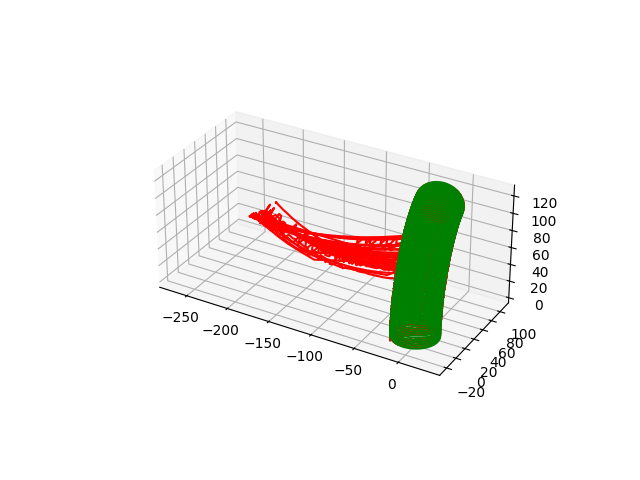

In [12]:
ax = plt.figure().add_subplot(projection='3d')
print(len(height_data))
layer_start = 1
layer_end = 80
for layer in height_data[layer_start:layer_end]:
    if not np.any(layer ==None):
        ax.plot3D(layer[:,0], layer[:,1], layer[:,2], 'r')
# for layer in height_data_no_off[layer_start:layer_end]:
#     if not np.any(layer ==None):
#         ax.plot3D(layer[:,0], layer[:,1], layer[:,2], 'b')

for layer in curve_sliced[layer_start:layer_end]:
    if not np.any(layer ==None):
        ax.plot3D(layer[:,0], layer[:,1], layer[:,2], 'g')
ax.set_aspect('equal')
plt.show()


-0.36997977325543796
80


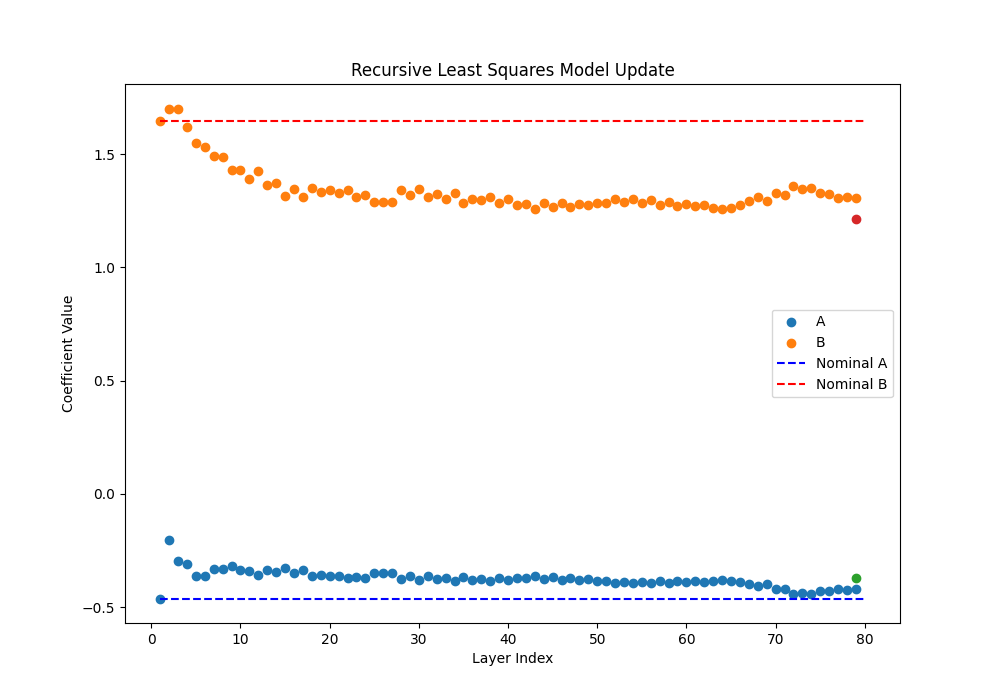

In [95]:
coeff_a = []
coeff_b = []
layer_start = 1
for layer in range(1,80):
    coeff_mat = np.loadtxt(f"{save_path}layer_{layer}/coeff_mat.csv")
    coeff_a.append(coeff_mat[0])
    coeff_b.append(coeff_mat[1])
coeff_a = np.array(coeff_a)
fig,ax = plt.subplots()
ax.scatter(np.linspace(layer_start,layer_start+len(coeff_a)-1,len(coeff_a)), coeff_a)
ax.scatter(np.linspace(layer_start,layer_start+len(coeff_b)-1,len(coeff_b)), coeff_b)
ax.plot([layer_start, layer_start+len(coeff_a)],[coeff_a[0], coeff_a[0]], 'b--')
ax.plot([layer_start, layer_start+len(coeff_b)],[coeff_b[0], coeff_b[0]], 'r--')
ax.legend(("A", "B", "Nominal A", "Nominal B"))
plt.gca().set_xlabel("Layer Index")
plt.gca().set_ylabel("Coefficient Value")
print(x_mat[0])
print(layer_start+len(coeff_a))
ax.scatter(layer_start+len(coeff_a)-1,x_mat[0])
ax.scatter(layer_start+len(coeff_a)-1,x_mat[1])
plt.gcf().set_size_inches(10,7)
ax.set_title(f"Recursive Least Squares Model Update")
plt.show()

In [18]:
# calculate cartesian velocities at each 

time_series = []
calc_vel = []
avg_vel = []
for layer in range(1,80):
    # Job line 3 doesn't exist?
    try:
        joint_idx_start = np.where(joint_angles[layer-1][:,1]==job_no_offset)[0][0]
    except:
        joint_idx_start = np.where(joint_angles[layer-1][:,1]==job_no_offset+1)[0][0]

    joint_angles_prev = joint_angles[layer-1][joint_idx_start-1,:]
    joint_angles_layer = joint_angles[layer-1][joint_idx_start:,:]
    pose_prev=robot.fwd(joint_angles_prev[2:8]).p
    time_prev = joint_angles_prev[0]
    
    time_series_layer = []
    job_nos_layer = []
    calc_vel_layer = []
    for i in range(joint_angles_layer.shape[0]):
    # calculate instantatneous velocity
        robot1_pose = robot.fwd(joint_angles_layer[i,2:8])
        cart_dif = robot1_pose.p - pose_prev
        time_stamp = joint_angles_layer[i][0]
        time_dif = time_stamp-time_prev
        time_prev = time_stamp
        cart_vel = cart_dif/time_dif
        time_prev = time_stamp
        pose_prev = robot1_pose.p
        lin_vel = np.sqrt(cart_vel[0]**2+cart_vel[1]**2+cart_vel[2]**2)
        calc_vel_layer.append(lin_vel)
        job_nos_layer.append(joint_angles_layer[i][1])
        time_series_layer.append(time_stamp)
    job_nos_layer = [i-job_no_offset for i in job_nos_layer]
    vel_avg = avg_by_line_vel(job_nos_layer, calc_vel_layer, 50)

    if not layer_dir[layer-1]:
            vel_avg = vel_avg[::-1]
    time_series.append(time_series_layer)
    calc_vel.append(calc_vel_layer)
    avg_vel.append(vel_avg)


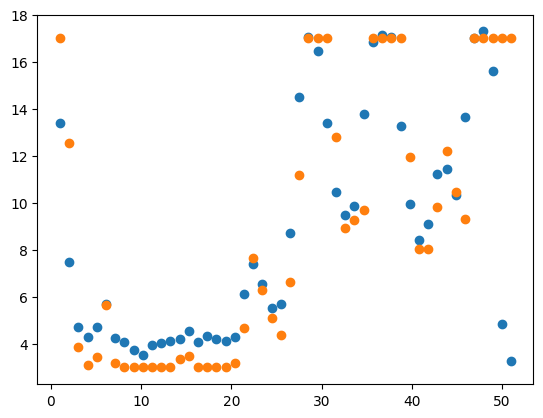

In [19]:
# Check velocities
layer = 16
plt.scatter(np.linspace(1,51,50), avg_vel[layer-1])
plt.scatter(np.linspace(1,51,50), set_vel[layer-1])

# Calculations

[4.062408829788567, 12.986628971944231]
[        nan  4.7089743   5.60567121  6.3907688   9.07194526 11.97296001
 10.13387885  7.53468794  5.76631748  5.33831194  5.01597591  4.79998457
  4.96186397  4.9725155   4.60522338  4.28376017  4.5015587   4.66709348
  4.66854169  4.58714644  4.37440687  4.30573656  4.13112823  4.16510988
  4.17962068  4.06240883  4.46106967  4.7259321   4.73350931  4.87508066
  4.75339964  5.06706195  5.09234788  6.09664643  6.73827019  6.972975
  7.0468995   6.21253006  5.11584407  4.50445187  5.54370009  6.97376572
  8.46552609  9.85227484 11.51373087 12.98662897  8.33261143  4.25790061
  5.52003599  8.62034276]
Coefficients:  [-0.29571731  1.1424663 ]


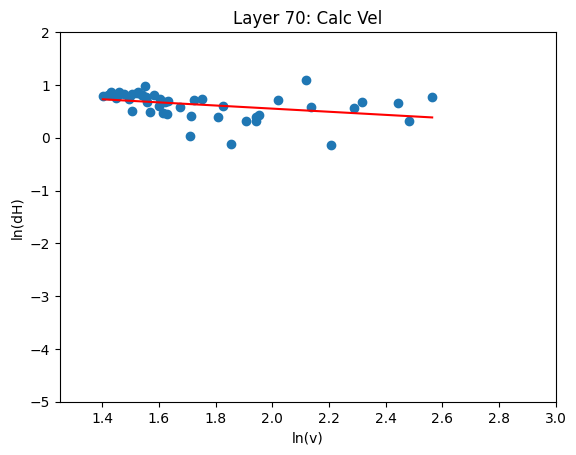

Coefficients:  [-0.32684455  1.15497407]


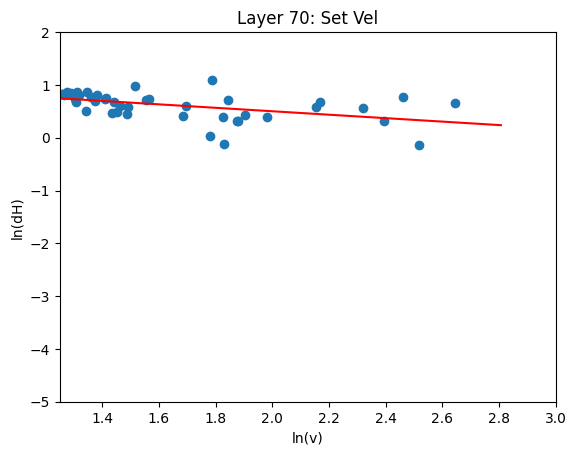

In [20]:
# Fit plots for the set velocity and measured velocity
layer = 70
dh = height_data[layer-1]-height_data_prev[layer-2]
model = speedHeightModel()
model.model_update(avg_vel[layer-1], dh, 1)
v_range = [np.nanmin(avg_vel[layer-1]), np.nanmax(avg_vel[layer-1])]
dh_fit = model.v2dh(v_range)
print(v_range)
print(avg_vel[layer-1])
print("Coefficients: ", model.coeff_mat)
fig, ax = plt.subplots()
ax.scatter(np.log(avg_vel[layer-1]),np.log(dh))
ax.plot(np.log(v_range), np.log(dh_fit), 'r')
ax.set_title(f"Layer {layer}: Calc Vel")
ax.set_ylabel("ln(dH)")
ax.set_xlabel("ln(v)")
ax.set_ylim(-5,2)
ax.set_xlim(1.25,3)
plt.show()
model.model_update(set_vel[layer-1], dh, weight=1)
v_range = [np.min(set_vel[layer-1]), np.max(set_vel[layer-1])]
dh_fit = model.v2dh(v_range)

print("Coefficients: ", model.coeff_mat)
fig, ax = plt.subplots()
ax.scatter(np.log(set_vel[layer-1]),np.log(dh))
ax.plot(np.log(v_range), np.log(dh_fit), 'r')
ax.set_title(f"Layer {layer}: Set Vel")
ax.set_ylabel("ln(dH)")
ax.set_xlabel("ln(v)")
ax.set_ylim(-5,2)
ax.set_xlim(1.25,3)
plt.show()

unsupported operand type(s) for -: 'NoneType' and 'float'
unsupported operand type(s) for -: 'NoneType' and 'float'


C:\Users\Motoman_PC\AppData\Local\Temp\ipykernel_18224\3854004776.py:165: RuntimeWarning: invalid value encountered in log
  y = np.log(dhs[idx])
C:\Users\Motoman_PC\AppData\Local\Temp\ipykernel_18224\3854004776.py:141: RuntimeWarning: invalid value encountered in log
  ln_dhs = np.log(np.array(dhs))


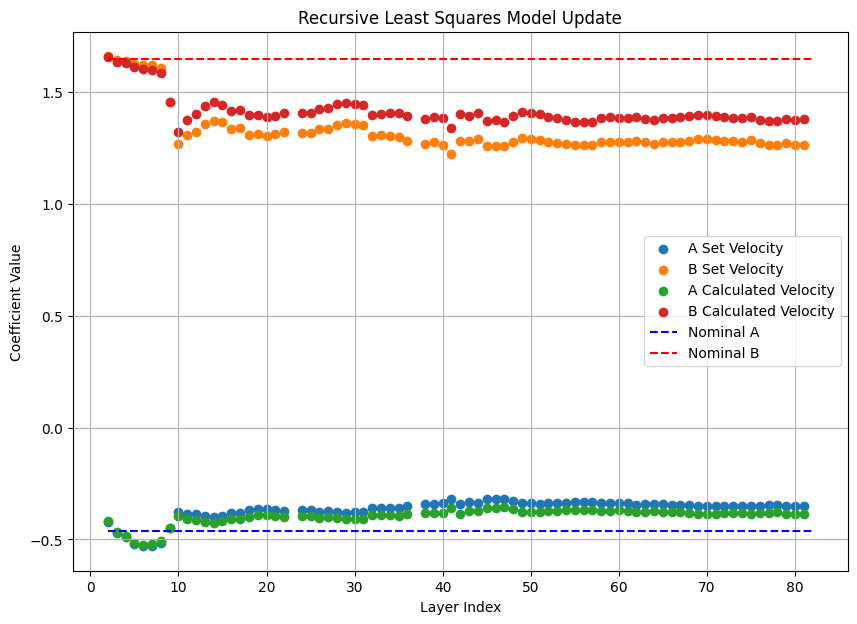

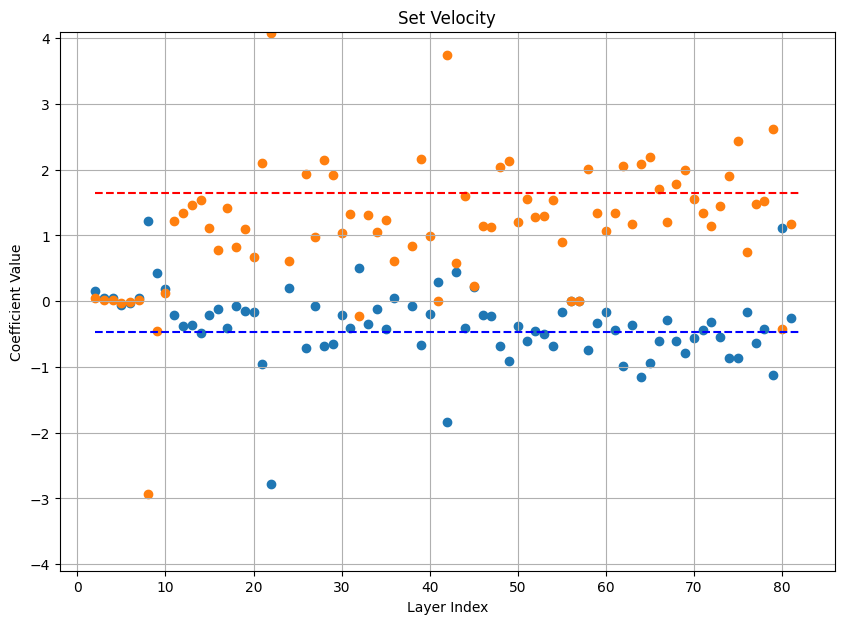

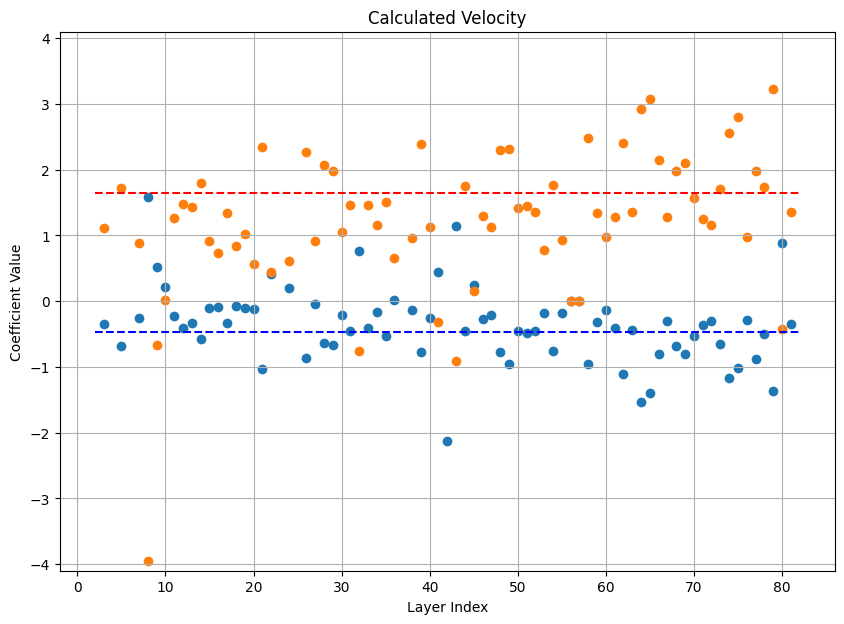

In [21]:
layer_start = 2
layer_end = 80
coeff_a = []
coeff_b = []
coeff_a_layer = []
coeff_b_layer = []
coeff_a_calc = []
coeff_b_calc = []
coeff_a_calc_layer = []
coeff_b_calc_layer = []

model_set = speedHeightModel()
model_set_layer = speedHeightModel()
model_calc = speedHeightModel()
model_calc_layer = speedHeightModel()
nom_coeff_a = model_set.coeff_mat[0]
nom_coeff_b = model_set.coeff_mat[1]
for layer in range(layer_start,layer_end):
    try:
        dh = height_data[layer-1]-height_data_prev[layer-2]
    except Exception as e:
        print(e)
        coeff_a.append(None)
        coeff_b.append(None)
        coeff_a_calc.append(None)
        coeff_b_calc.append(None)
        coeff_a_layer.append(None)
        coeff_b_layer.append(None)
        coeff_a_calc_layer.append(None)
        coeff_b_calc_layer.append(None)

    model_set.model_update_RLS(set_vel[layer-1][1:-2], dh[1:-2])
    model_calc.model_update_RLS(avg_vel[layer-1][1:-2], dh[1:-2])
    model_set_layer.model_update(set_vel[layer-1][1:-2], dh[1:-2],1)
    model_calc_layer.model_update(avg_vel[layer-1][1:-2], dh[1:-2],1)
    coeff_a.append(model_set.coeff_mat[0])
    coeff_b.append(model_set.coeff_mat[1])
    coeff_a_calc.append(model_calc.coeff_mat[0])
    coeff_b_calc.append(model_calc.coeff_mat[1])
    coeff_a_layer.append(model_set_layer.coeff_mat[0])
    coeff_b_layer.append(model_set_layer.coeff_mat[1])
    coeff_a_calc_layer.append(model_calc_layer.coeff_mat[0])
    coeff_b_calc_layer.append(model_calc_layer.coeff_mat[1])
   

plt.scatter(np.linspace(layer_start,layer_start+len(coeff_a)-1,len(coeff_a)), coeff_a)
plt.scatter(np.linspace(layer_start,layer_start+len(coeff_b)-1,len(coeff_b)), coeff_b)
plt.scatter(np.linspace(layer_start,layer_start+len(coeff_a_calc)-1,len(coeff_a_calc)), coeff_a_calc)
plt.scatter(np.linspace(layer_start,layer_start+len(coeff_b_calc)-1,len(coeff_b_calc)), coeff_b_calc)
plt.plot([layer_start, layer_start+len(coeff_a)],[nom_coeff_a, nom_coeff_a], 'b--')
plt.plot([layer_start, layer_start+len(coeff_b)],[nom_coeff_b, nom_coeff_b], 'r--')
plt.legend(("A Set Velocity", "B Set Velocity","A Calculated Velocity", "B Calculated Velocity", "Nominal A", "Nominal B", "Average A", "Average B"))
plt.gca().set_xlabel("Layer Index")
plt.gca().set_ylabel("Coefficient Value")
plt.gca().grid()
plt.gcf().set_size_inches(10,7)
plt.title(f"Recursive Least Squares Model Update")
plt.show()

plt.scatter(np.linspace(layer_start,layer_start+len(coeff_a_layer)-1,len(coeff_a_layer)), coeff_a_layer)
plt.scatter(np.linspace(layer_start,layer_start+len(coeff_b_layer)-1,len(coeff_b_layer)), coeff_b_layer)
plt.plot([layer_start, layer_start+len(coeff_a)],[nom_coeff_a, nom_coeff_a], 'b--')
plt.plot([layer_start, layer_start+len(coeff_b)],[nom_coeff_b, nom_coeff_b], 'r--')
plt.gca().set_ylim(-4.1,4.1)
plt.gca().set_xlabel("Layer Index")
plt.gca().set_ylabel("Coefficient Value")
plt.gca().grid()
plt.gcf().set_size_inches(10,7)
plt.gca().set_title("Set Velocity")
plt.show()

plt.scatter(np.linspace(layer_start,layer_start+len(coeff_a_calc_layer)-1,len(coeff_a_calc_layer)), coeff_a_calc_layer)
plt.scatter(np.linspace(layer_start,layer_start+len(coeff_b_calc_layer)-1,len(coeff_b_calc_layer)), coeff_b_calc_layer)
plt.plot([layer_start, layer_start+len(coeff_a)],[nom_coeff_a, nom_coeff_a], 'b--')
plt.plot([layer_start, layer_start+len(coeff_b)],[nom_coeff_b, nom_coeff_b], 'r--')
plt.gca().set_ylim(-4.1,4.1)
plt.gca().set_xlabel("Layer Index")
plt.gca().set_ylabel("Coefficient Value")
plt.gca().grid()
plt.gcf().set_size_inches(10,7)
plt.gca().set_title("Calculated Velocity")
plt.show()

# Simulation based on models

In [22]:
# Model Setup
def delta_v(v):
    delta_v = [v[i]-v[i+1] for i in range(len(v)-1)]
    return delta_v
def v_opt(v_next, v_prev, h_err, h_targ, lam, beta):
    return norm(h_targ+h_err-v2dh(v_next), 2)**2 + lam*norm(v_next-v_prev, 2)**2 + beta*norm(delta_v(v_next), 2)**2



noisy_coeff_a = []
noisy_coeff_b = []
for val in coeff_a_calc_layer:
    if val != None :
        noisy_coeff_a.append(val)
for val in coeff_b_calc_layer:
    if val != None :
        noisy_coeff_b.append(val)

np.random.shuffle(noisy_coeff_a)
np.random.shuffle(noisy_coeff_b)
print(np.mean(noisy_coeff_a))
print(np.mean(noisy_coeff_b))


num_layers = 80
part_len = 50 #mm
v_min = 5
max_dH = v2dh(v_min)
v_max = 15
min_dH = v2dh(v_max)
points_per_layer = 50

layer_angle = np.arcsin((max_dH-min_dH)/part_len)
rot_point = max_dH/np.tan(layer_angle)-part_len/2
print(np.rad2deg(layer_angle))
print(rot_point)
print(max_dH)
print(min_dH)
print(np.rad2deg(num_layers*layer_angle))


0.42665861663700444
-0.9301256520302076
1.1257976619508032
100.6131657840027
2.468475190539253
1.4860946104132609
90.06381295606425


Final Height Error:  13.950250651624245


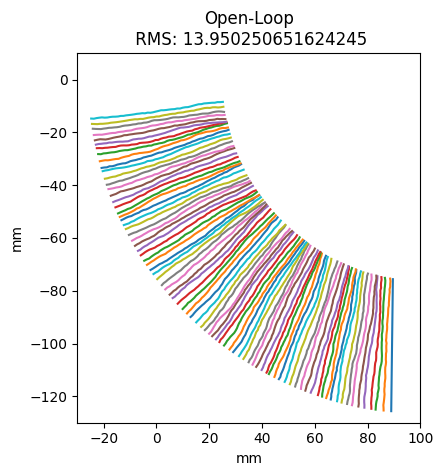

In [23]:
np.random.seed(1234)
def noisy_profile(nom_profile):
    noise = (np.random.rand(len(nom_profile))-0.5)*5
    #noise_profile = savgol_filter(noise+nom_profile, int(len(nom_profile/20)), 10, mode='interp')
    noise_profile = uniform_filter1d(noise+nom_profile, 20)
    # noise_profile = noise+nom_profile
    return noise_profile
# nominal layer plot
layers = []
x_vals = np.linspace(-part_len/2, part_len/2, points_per_layer)
height_profile = np.linspace(max_dH, min_dH, points_per_layer)
vel_nom = dh2v(height_profile)

curve_curved=np.zeros((num_layers*points_per_layer,2))
new_x, new_y = rotate((rot_point,0), (x_vals, height_profile), layer_angle)
# first layer
curve_curved[:points_per_layer, 0] = x_vals
curve_curved[:points_per_layer, 1] = v2dh_noised(vel_nom)+10
offset = 0
for i in range(1,num_layers):
    if not(coeff_a[i-offset] == None or coeff_b[i-offset] == None):
        model = speedHeightModel(coeff_mat=[coeff_a[i], coeff_b[i]])
    else:
        model = speedHeightModel(coeff_mat=model.coeff_mat)
        offset += 1
    new_x, new_y = rotate((rot_point,0), (curve_curved[:points_per_layer*i+1, 0], curve_curved[:points_per_layer*i+1,1]), layer_angle)
    curve_curved[:i*points_per_layer+1, :] = np.array([new_x, new_y]).T
    curve_curved[i*points_per_layer:(i+1)*points_per_layer, 0] = x_vals
    curve_curved[i*points_per_layer:(i+1)*points_per_layer, 1] = noisy_profile(model.v2dh(vel_nom)+curve_curved[(i-1)*points_per_layer:i*points_per_layer, 1])
#final rotation
curve_curved[:,0], curve_curved[:,1] = rotate((rot_point,0), (curve_curved[:, 0], curve_curved[:,1]), layer_angle)
final_error = np.sqrt(np.sum(curve_curved[(i-1)*points_per_layer:i*points_per_layer, 1]**2)/
                                      len(curve_curved[(i-1)*points_per_layer:i*points_per_layer, 1]))
print("Final Height Error: ", final_error)
fig,ax = plt.subplots()
for i in range(num_layers):
    ax.plot(curve_curved[i*points_per_layer:(i+1)*points_per_layer,0], curve_curved[i*points_per_layer:(i+1)*points_per_layer,1])
ax.set_aspect('equal')
ax.set_xlim(-30,100)
ax.set_ylim(-130, 10)
ax.set_title(f"Open-Loop\n RMS: {final_error}")
ax.set_xlabel("mm")
ax.set_ylabel("mm")
plt.show()